# Solution to Problem 3 in Homework 10

(a) For the channel used in the notebook (see section entitled
"Estimating the channel impulse response" in the notebook for
the channel and the construction of the received signal) compute
the mean-squared error of the equalizer outputs, i.e., the mean
of the magnitude-squared difference between the equalizer output
and the transmitted symbols. Compare the MSE to the noise
variance.

(b) Repeat your measurement for an equalizer that spans $K=20$
sample periods (instead of $K=40$).

(c) Repeat your measurement for an equalizer that spans $K=80$
sample periods. You will likely need to increase the number of
training symbols and also the total number of symbols.

(d) For this channel, spanning five symbol periods, what is a
good length of the equalizer?


In [5]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
from scipy.linalg import toeplitz

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

## Copy Code from Notebook

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

## Simulations

### Generate the Received Signal

In [4]:
## generate a QPSK signal
fsT = 4
N = 1000
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

syms = random_symbols(A, N)

## dispersive channel
cr = np.array([0.1, 0, -0.3j, 0, 0, 1, 0, 0, 0, 0.3j, 0, 0, 0, 0, 0.2-0.7j, 0, 0, 0, 0, 0, 0.1j])
sig = pulse_shape(syms, cr, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

# received signal
rrr = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))

### Estimate the channel impulse response

In [8]:
## construct the matrix S via upsampling and use of scipy.linalg.toeplitz
# the first columns of S is the upsampled symbols vector
sc = np.zeros_like(rrr)
sc[0:N*fsT:fsT] = syms

# the first row is [syms[0], 0, ..., 0]
sr = np.zeros_like(cr)
sr[0] = syms[0]

SSr = toeplitz(sc, sr)

In [9]:
# using the received vector `rrr` and signal matrix `SSr` constructed earlier
this_K = 48*4               # number of received samples to use
this_rr = rrr[:this_K]    # trim rr
this_SS = SSr[:this_K, :] # and SS

c_hat = np.linalg.pinv(this_SS) @ this_rr

np.mean(np.abs(rrr - SSr@c_hat)**2)

0.011090263090908423

## Zero-Forcing Equalizer

For equalizer lengths of $K \in \{20, 40, 80\}$ samples, design a zero-forcing equalizer and measure the MSE.

This follows the notebook with two exceptions:
1. The construction of the channel matrix $\mathbf{C}$ has been corrected. The original version produces a matrix that is not tall enough for short equalizers (sall $K$).
2. The sampling phase of the equalizer output depends on the equalizer length. The correct phase for the three lengths have been determined experimentally.

K = 40: MSE = -21.54 dB
K = 20: MSE = -21.26 dB
K = 80: MSE = -21.55 dB


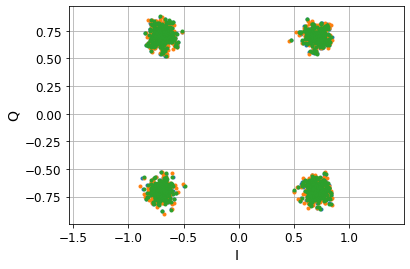

In [91]:
## Construct and apply equalizer for three differnt equalizer length
all_K = [40, 20, 80]
phase = {20: -1, 40: 1, 80: 1}

for K in all_K:
    L = len(c_hat)
    fsT = 4

    # there is probably a better way to construct the channel matrix, but ...
    # initially we construct the first 2K rows of C; we need N columns
    N = (K+L-1) // fsT
    C_tmp = np.zeros((N*fsT+L, N), dtype=complex)
    for n in range(N):
        C_tmp[n*fsT:n*fsT+L, n] = c_hat

    # then, we select K rows that don't contain empty columns
    C_hat = C_tmp[L-1:L-1+K, :]
    
    # set up the unit vector with a 1 in the d-th position
    ed = np.zeros_like(C_hat[0,:])
    ed[N//2] = 1

    # find the weight vector
    vr = (np.linalg.pinv(C_hat).T).conj() @ ed

    # and the impulse response of the equalizer
    wr = np.flip(vr.conj())

    # equalize the signal
    rr_eq = np.convolve(rrr, wr)

    ## constellation plot
    # exclude transients
    ns = (len(cr) + len(wr)) // 2 + phase[K] # leading transient due to filter delays
    ne = ns + len(syms) * fsT         # take len(syms) qualizer outputs

    syms_eq = rr_eq[ns:ne:fsT]

    plt.plot(rr_eq[ns:ne:fsT].real, rr_eq[ns:ne:fsT].imag, '.', label='K={:d}'.format(K))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')

    print('K = {:d}: MSE = {:4.2f} dB'.format(K, 10*np.log10(np.linalg.norm(syms-syms_eq)**2/len(syms))))


For all three equalizer lengths, the signal is successfully equalized. The measured MSE is nearly identical for all three cases and similar to the (negative of the) SNR (i.e., 20dB). We can conclude that for this channel, noise amplification is not a significant problem.

The shortest effective equalizer should be selected to minimize the computational complexity.